In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import model_selection, datasets
import joblib
import pickle
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import itertools

In [2]:
df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
df.head()

,path,type,diagnose
0,./Brain scans\Tumor\TRAIN\y0.jpg,brain,tumor
1,./Brain scans\Tumor\TRAIN\y1.jpg,brain,tumor
2,./Brain scans\Tumor\TRAIN\y10.jpg,brain,tumor
3,./Brain scans\Tumor\TRAIN\y100.jpg,brain,tumor
4,./Brain scans\Tumor\TRAIN\y101.jpg,brain,tumor


In [3]:
y_train = df[df['type'] == "breast"]['diagnose']
y_test = test_df[test_df['type'] == "breast"]['diagnose']

In [179]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
x_train = []
x_test = []
for path in df[df['type'] == "breast"]["path"]:
    x_train.append(cv2.resize(cv2.imread(path), (500,500)))
for path in test_df[test_df['type'] == "breast"]["path"]:
    x_test.append(cv2.resize(cv2.imread(path), (500,500)))

In [180]:
x_train = pd.Series(x_train)
x_test = pd.Series(x_test)

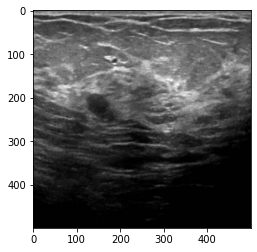

In [181]:
plt.imshow(x_train[204])

In [182]:
def Feature_extractor(image):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, multichannel=True)
    return fd, hog_image

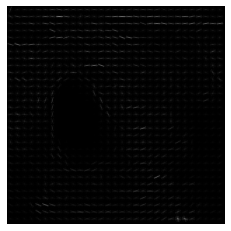

In [183]:
plt.axis("off")
fd, hog_image = Feature_extractor(x_train[101])
plt.imshow(hog_image, cmap="gray")

In [184]:
hog_features = []
hog_images = []
for image in x_train:
    fd, hog_image = Feature_extractor(image)
    hog_features.append(fd)
    hog_images.append(hog_image)

In [185]:
hog_features = np.array(hog_features)

In [102]:
# hog_features_2 = []
# hog_images_2 = []
# for image in x_train:
#     fd, hog_image = Feature_extractor(image)
#     hog_features_2.append(fd)
#     hog_images_2.append(hog_image)

In [103]:
# hog_features_2 = np.array(hog_features_2)

In [186]:
hog_features.shape

(681, 8649)

In [187]:
new_df = pd.DataFrame(data = hog_features)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8639,8640,8641,8642,8643,8644,8645,8646,8647,8648
0,0.363374,0.363374,0.317008,0.209323,0.363374,0.251882,0.363374,0.363374,0.363374,0.374231,...,0.170628,0.354380,0.354380,0.354380,0.354380,0.354380,0.354380,0.322731,0.297047,0.232586
1,0.359969,0.317636,0.301655,0.220736,0.359969,0.356109,0.338029,0.359969,0.359969,0.260074,...,0.019196,0.114058,0.319436,0.463029,0.463029,0.463029,0.345946,0.276794,0.211971,0.023220
2,0.384534,0.384534,0.384534,0.165226,0.384534,0.351190,0.285375,0.169107,0.384534,0.233124,...,0.025548,0.303004,0.202823,0.396597,0.396597,0.396597,0.396597,0.232868,0.396597,0.162411
3,0.414007,0.414007,0.186801,0.175339,0.414007,0.246168,0.317054,0.296028,0.414007,0.184637,...,0.005898,0.199099,0.328307,0.464981,0.464981,0.464981,0.372881,0.223514,0.112469,0.048007
4,0.039861,0.015928,0.155234,0.630304,0.747248,0.112482,0.068393,0.013999,0.029509,0.073608,...,0.036521,0.051064,0.078997,0.267681,0.666088,0.666088,0.174812,0.033376,0.020825,0.006842


In [36]:
# new_df_2 = pd.DataFrame(data = hog_features_2)
# new_df_2.head()

In [37]:
# new_df = pd.concat([new_df, new_df_2], axis = 1)
# new_df.head()

In [188]:
# new_df['label'] = df[:681]['diagnose']
# temp_df = df[df['type'] == "breast"]
# new_df['label'] = temp_df['diagnose']

# temp_df['diagnose']
encoded_y_train = []
for string in y_train:
    if string == "benign":
        encoded_y_train.append("b")
    if string == "malignant":
        encoded_y_train.append("m")
    if string == "normal":
        encoded_y_train.append("n")
encoded_y_train = pd.Series(encoded_y_train)
new_df["label"]=encoded_y_train
new_df = shuffle(new_df)

In [189]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8640,8641,8642,8643,8644,8645,8646,8647,8648,label
630,0.131056,0.136782,0.303150,0.517385,0.517385,0.517385,0.230247,0.113187,0.057686,0.185475,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,n
454,0.335152,0.335152,0.318412,0.335152,0.335152,0.335152,0.335152,0.335152,0.335152,0.355809,...,0.147791,0.276034,0.470907,0.470907,0.470907,0.470907,0.117867,0.025591,0.020037,m
552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,m
605,0.150563,0.044726,0.146584,0.354918,0.495190,0.495190,0.459889,0.324647,0.143376,0.125944,...,0.360440,0.203884,0.315591,0.360440,0.360440,0.360440,0.360440,0.360440,0.281658,n
43,0.367138,0.339902,0.367138,0.367138,0.367138,0.367138,0.338532,0.296965,0.087874,0.259129,...,0.322211,0.229512,0.380593,0.380593,0.380593,0.380593,0.184604,0.338269,0.339995,b


In [190]:
X_Train = new_df.loc[:, new_df.columns != 'label']
Y_Train = new_df['label']

In [191]:
X_Train.head()

,0,1,2,3,4,5,6,7,8,9,...,8639,8640,8641,8642,8643,8644,8645,8646,8647,8648
630,0.131056,0.136782,0.303150,0.517385,0.517385,0.517385,0.230247,0.113187,0.057686,0.185475,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
454,0.335152,0.335152,0.318412,0.335152,0.335152,0.335152,0.335152,0.335152,0.335152,0.355809,...,0.036828,0.147791,0.276034,0.470907,0.470907,0.470907,0.470907,0.117867,0.025591,0.020037
552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
605,0.150563,0.044726,0.146584,0.354918,0.495190,0.495190,0.459889,0.324647,0.143376,0.125944,...,0.333333,0.360440,0.203884,0.315591,0.360440,0.360440,0.360440,0.360440,0.360440,0.281658
43,0.367138,0.339902,0.367138,0.367138,0.367138,0.367138,0.338532,0.296965,0.087874,0.259129,...,0.185515,0.322211,0.229512,0.380593,0.380593,0.380593,0.380593,0.184604,0.338269,0.339995


In [192]:
Y_Train

630    n
454    m
552    m
605    n
43     b
      ..
408    m
150    b
220    b
11     b
394    b
Name: label, Length: 681, dtype: object

In [193]:
test_hog_features = []
test_hog_images = []
for image in x_test:
    fd, hog_image = Feature_extractor(image)
    test_hog_features.append(fd)
    test_hog_images.append(hog_image)

In [114]:
# test_hog_features_2 = []
# test_hog_images_2 = []
# for image in x_test:
#     fd, hog_image = Feature_extractor(image)
#     test_hog_features_2.append(fd)
#     test_hog_images_2.append(hog_image)

In [194]:
new_test_df = pd.DataFrame(data = test_hog_features)
# new_test_df_2 = pd.DataFrame(data = test_hog_features_2)
# new_test_df = pd.concat([new_test_df, new_test_df_2], axis = 1)
encoded_y_test = []
for string in y_test:
    if string == "benign":
        encoded_y_test.append("b")
    if string == "malignant":
        encoded_y_test.append("m")
    if string == "normal":
        encoded_y_test.append("n")
encoded_y_test = pd.Series(encoded_y_test)
new_test_df['label'] = encoded_y_test
new_test_df = shuffle(new_test_df)
X_Test = new_test_df.loc[:, new_test_df.columns != 'label']
Y_Test = new_test_df['label']

In [22]:
gbt = GradientBoostingClassifier(learning_rate = 0.3,n_estimators = 180)
gbt.fit(X_Train, Y_Train)
gbt.score(X_Train,Y_Train)

1.0

In [23]:
gbt_y_pred = gbt.predict(X_Test)
accuracy_score(gbt_y_pred,Y_Test)

0.5151515151515151

In [45]:
rst = RandomForestClassifier(n_estimators = 120, max_features = 10)
rst.fit(X_Train, Y_Train)
rst.score(X_Train,Y_Train)

1.0

In [46]:
rst_y_pred = rst.predict(X_Test)
accuracy_score(rst_y_pred,Y_Test)

0.48484848484848486

In [195]:
from sklearn.neural_network import MLPClassifier

In [196]:
ann = MLPClassifier(solver='lbfgs', alpha=1e-10, hidden_layer_sizes=(15,15), random_state=1,warm_start=True)

In [197]:
ann.fit(X_Train, Y_Train)
ann.score(X_Train,Y_Train)

1.0

In [198]:
ann_y_pred = ann.predict(X_Test)
accuracy_score(ann_y_pred,Y_Test)

0.5353535353535354

In [50]:
ada = AdaBoostClassifier()
ada.fit(X_Train, Y_Train)
ada.score(X_Train, Y_Train)

0.7738619676945668

In [51]:
ada_y_pred = ada.predict(X_Test)
accuracy_score(ada_y_pred,Y_Test)

0.46464646464646464

In [126]:
from scikit-image.features import greycomatrix, greycoprops
from scikit-image import io

SyntaxError: invalid syntax (<ipython-input-126-7bd16f0dfc32>, line 1)

In [130]:
from pyimagesearch.localbinarypatterns import LocalBinaryPatterns
from imutils import paths
import argparse

In [131]:
desc = LocalBinaryPatterns(24, 8)
data = []
labels = []

In [150]:
x_train = []
x_test = []
for path in df[df['type'] == "breast"]["path"]:
    img = cv2.resize(cv2.imread(path,0), (200,200))
    x_train.append(img)
    data.append(desc.describe(img))
for path in test_df[test_df['type'] == "breast"]["path"]:
    img = cv2.resize(cv2.imread(path,0), (200,200))
    x_test.append(desc.describe(img))

In [156]:
temp_train = pd.Series(x_train)
temp_train.shape(

KeyError: 0

In [165]:
new_x_train =[]
for img in x_train:
    new_x_train.append(img.flatten().tolist())


In [166]:
new_x_train[0]

[41,
 9,
 120,
 123,
 3,
 204,
 190,
 198,
 203,
 193,
 186,
 188,
 186,
 184,
 187,
 188,
 192,
 184,
 176,
 181,
 180,
 179,
 180,
 189,
 195,
 195,
 198,
 201,
 196,
 198,
 206,
 206,
 206,
 205,
 197,
 199,
 202,
 197,
 199,
 197,
 187,
 180,
 181,
 183,
 201,
 199,
 200,
 203,
 198,
 192,
 189,
 187,
 181,
 173,
 172,
 175,
 182,
 177,
 181,
 175,
 178,
 188,
 188,
 184,
 182,
 180,
 175,
 169,
 169,
 171,
 175,
 177,
 176,
 175,
 175,
 174,
 170,
 167,
 172,
 175,
 177,
 182,
 182,
 176,
 180,
 182,
 187,
 192,
 192,
 191,
 184,
 183,
 180,
 180,
 185,
 183,
 184,
 186,
 191,
 200,
 196,
 197,
 197,
 201,
 198,
 186,
 183,
 185,
 176,
 175,
 178,
 174,
 180,
 192,
 187,
 178,
 174,
 176,
 187,
 193,
 192,
 191,
 196,
 196,
 183,
 172,
 174,
 185,
 183,
 174,
 177,
 180,
 172,
 177,
 179,
 181,
 182,
 183,
 182,
 183,
 182,
 179,
 176,
 174,
 172,
 175,
 175,
 177,
 181,
 180,
 179,
 186,
 187,
 179,
 181,
 184,
 183,
 183,
 175,
 171,
 176,
 193,
 196,
 200,
 197,
 187,
 195,
 18

In [169]:
temp_df = pd.DataFrame(data = new_x_train)
temp_df.head()
encoded_y_train = []
for string in y_train:
    if string == "benign":
        encoded_y_train.append("b")
    if string == "malignant":
        encoded_y_train.append("m")
    if string == "normal":
        encoded_y_train.append("n")
encoded_y_train = pd.Series(encoded_y_train)
temp_df["label"]=encoded_y_train
temp_df = shuffle(temp_df)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39991,39992,39993,39994,39995,39996,39997,39998,39999,label
346,23,168,177,193,203,193,185,177,186,194,...,21,22,25,23,22,22,23,23,20,b
286,174,182,181,194,204,201,198,187,169,169,...,27,22,20,25,25,22,26,25,19,b
124,156,102,125,118,99,233,233,230,229,215,...,20,21,17,15,20,21,20,19,24,b
493,204,3,177,204,129,40,207,210,207,218,...,22,25,29,28,23,20,22,21,21,m
638,150,158,171,161,150,146,146,148,158,157,...,21,12,10,16,16,15,14,15,13,n


In [171]:
X_Train = temp_df.loc[:, temp_df.columns != 'label']
Y_Train = temp_df['label']

In [172]:
ann = MLPClassifier(solver='lbfgs', alpha=1e-10, hidden_layer_sizes=(15,15), random_state=1,warm_start=True)
ann.fit(X_Train,Y_Train)
ann.score(X_Train,Y_Train)

C:\Users\beboz\.conda\envs\computervision\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.5844346549192364

In [173]:
new_x_test =[]
for img in x_test:
    new_x_test.append(img.flatten().tolist())

In [174]:
temp_df = pd.DataFrame(data = new_x_test)
temp_df.head()
encoded_y_test = []
for string in y_test:
    if string == "benign":
        encoded_y_test.append("b")
    if string == "malignant":
        encoded_y_test.append("m")
    if string == "normal":
        encoded_y_test.append("n")
encoded_y_test = pd.Series(encoded_y_test)
temp_df["label"]=encoded_y_test
temp_df = shuffle(temp_df)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
5,0.038275,0.036150,0.018375,0.009575,0.008700,0.008125,0.006850,0.007350,0.008475,0.009350,...,0.007325,0.005175,0.005725,0.005525,0.007325,0.010775,0.029200,0.036850,0.658000,b
50,0.036250,0.035550,0.011125,0.007900,0.006675,0.005325,0.005175,0.006125,0.005150,0.007600,...,0.006575,0.004025,0.004800,0.004475,0.007250,0.009550,0.026725,0.027975,0.708375,m
48,0.035025,0.034075,0.014625,0.007350,0.005800,0.005275,0.006075,0.006975,0.008900,0.010000,...,0.008250,0.006050,0.006075,0.005825,0.007850,0.012450,0.024600,0.030750,0.665950,m
4,0.035675,0.033325,0.017225,0.012300,0.007225,0.007325,0.007975,0.008250,0.008325,0.010425,...,0.007475,0.004900,0.004825,0.005050,0.008075,0.011025,0.026325,0.026550,0.677325,b
34,0.034700,0.029425,0.011250,0.006700,0.003650,0.003300,0.003025,0.004125,0.005600,0.007400,...,0.009850,0.004500,0.006650,0.003525,0.007425,0.010175,0.054350,0.168875,0.553550,b


In [175]:
X_Test = temp_df.loc[:, temp_df.columns != 'label']
Y_Test = temp_df['label']

In [176]:
ann_y_pred = ann.predict(X_Test)
accuracy_score(ann_y_pred,Y_Test)

ValueError: X has 26 features, but MLPClassifier is expecting 40000 features as input.